In [162]:
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import seaborn as sns

import math
import torch.nn as nn
import torch
import torch.utils
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [163]:
l = ['difpoint535455', 'difpoint565758', 'difpoint596061', 'difpoint626364', '3diftrue']

In [290]:
def make_dataset(path):
    file = np.load(os.path.join('plots/', path, 'plane.npz'))
    X = file['grid'].reshape(-1, 2)
    X[:, 0] = (X[:, 0] - X[:, 0].mean())/X[:, 0].max()
    X[:, 1] = (X[:, 1] - X[:, 1].mean())/X[:, 1].max()
    y = file['te_err'].reshape(-1)
    
    return X, y

In [291]:
X_arr = []
y_arr = []
for f in l:
    X, y = make_dataset(f)
    X_arr.append(X)
    y_arr.append(y)
    
X = np.vstack(X_arr)
y = np.concatenate(y_arr)

In [292]:
max(X[:, 0])

0.5833333333333335

In [293]:
min(X[:, 0])

-0.5833333333333334

In [294]:
y.shape

(2205,)

In [295]:
X[:, 1].var()

0.12476851851851854

In [485]:
class Quadric(nn.Module):
    def __init__(self, ):
        super(Quadric, self).__init__()
        
#         data_Q = torch.FloatTensor(np.random.normal(size=(2,2)))
#         data_P = torch.FloatTensor(np.random.normal(size=(2,)))
#         data_R = torch.FloatTensor(np.random.normal(size=(1,)))
#         data_b = torch.FloatTensor(np.random.normal(size=(1,)))
        const = 10
        data_Q = torch.FloatTensor([[const, 0], [0,const]])
        data_P = const*torch.FloatTensor([0.5, 0.5])
        data_R = const*torch.FloatTensor([0.5])
        data_b = torch.FloatTensor([0])
        data_b1 = torch.FloatTensor([0.])
        data_a = torch.FloatTensor([1])
#         data_p = torch.FloatTensor([1])
        
        self.Q = nn.Parameter(data = data_Q, requires_grad=True)
        self.P = nn.Parameter(data = data_P, requires_grad=True)
        self.R = nn.Parameter(data = data_R, requires_grad=True)
        self.b = nn.Parameter(data = data_b, requires_grad=True)
        self.b1 = nn.Parameter(data = data_b1, requires_grad=True)
        self.a = nn.Parameter(data = data_a, requires_grad=True)

    def forward(self, x):
        
        q = x @ self.Q 
        q = (x*q).sum(-1)
        p = x @ self.P
        out = nn.ReLU()(torch.abs(q+p+self.R)+self.b)
        out = self.a*out.pow(4)+self.b1

        return out

    
class Appr(nn.Module):
    def __init__(self, ):
        super(Appr, self).__init__()
        
        self.Q1 = Quadric()
        self.Q2 = Quadric()
        self.Q3 = Quadric()
        
#         self.Q1.Q.data.copy_(torch.FloatTensor([[1, 0], [0,1]]))
        const=10
        self.Q1.P.data.copy_(const*torch.FloatTensor([0, -0.5]))
        self.Q2.P.data.copy_(const*torch.FloatTensor([-0.5, 0.5]))
        self.Q3.P.data.copy_(const*torch.FloatTensor([0.5, 0.5]))
        self.Q1.R.data.copy_(const*torch.FloatTensor([0.25]))
        self.Q2.R.data.copy_(const*torch.FloatTensor([0.5]))
        self.Q3.R.data.copy_(const*torch.FloatTensor([0.5]))
        

    def forward(self, x):
        
        x1 = self.Q1(x)
        x2 = self.Q2(x)
        x3 = self.Q3(x)

        out = torch.min(x1, x2)
        
        out = torch.min(x3, out)
        
        return out
    
    
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        
        self.mid = 10
        
        self.seq = nn.Sequential(
            nn.Linear(2, self.mid),
            nn.Tanh(),
            nn.Linear(self.mid, self.mid),
            nn.Tanh(),
            nn.Linear(self.mid, 1),
        )
               

    def forward(self, x):
        
        out = self.seq(x)

        return out
    

In [486]:
model = Appr()

In [487]:
# list(model.parameters())

In [488]:
model.cuda()

Appr(
  (Q1): Quadric()
  (Q2): Quadric()
  (Q3): Quadric()
)

In [489]:
# list(model.parameters())

In [490]:
# list(model.parameters())[-1].requires_grad_(False)
# list(model.parameters())[-1].requires_grad_(True)

In [491]:
def iterate_minibatches(train_data, train_labels, batchsize):
    indices = np.random.permutation(np.arange(len(train_labels)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield torch.FloatTensor(train_data[ix]).cuda(), torch.FloatTensor(train_labels[ix]).cuda()

In [514]:
criterion = nn.MSELoss()
# criterion = nn.L1Loss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

from sklearn.metrics import accuracy_score

def train(model, criterion, optimizer, X, y, batch_size=128, n_epochs=3):

    for epoch in range(n_epochs):
        for X_tr, y_true in iterate_minibatches(X, y, batch_size):

            y_pred = model(X_tr)
#             print(y_pred.shape, y_true.shape)
            loss = criterion(y_true, y_pred)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch % 1000 ==0):
            print('loss:', loss)
        
    print("Finished!")

In [520]:
model.Q2.Q

Parameter containing:
tensor([[-5.5696,  4.9947],
        [ 4.9947,  2.4407]], device='cuda:0', requires_grad=True)

In [522]:
model.Q3.Q = model.Q2.Q

In [532]:
train(model, criterion, optimizer, X, y, batch_size=1024, n_epochs=10000)

loss: tensor(265.4445, device='cuda:0', grad_fn=<MeanBackward1>)
loss: tensor(272.6528, device='cuda:0', grad_fn=<MeanBackward1>)
loss: tensor(197.3880, device='cuda:0', grad_fn=<MeanBackward1>)
loss: tensor(188.2413, device='cuda:0', grad_fn=<MeanBackward1>)
loss: tensor(204.6094, device='cuda:0', grad_fn=<MeanBackward1>)
loss: tensor(204.9488, device='cuda:0', grad_fn=<MeanBackward1>)
loss: tensor(190.7106, device='cuda:0', grad_fn=<MeanBackward1>)
loss: tensor(171.8622, device='cuda:0', grad_fn=<MeanBackward1>)
loss: tensor(156.9225, device='cuda:0', grad_fn=<MeanBackward1>)
loss: tensor(154.4530, device='cuda:0', grad_fn=<MeanBackward1>)
Finished!


In [528]:
# y, y_pred

In [529]:
list(model.parameters())

[Parameter containing:
 tensor([[2.7586, 0.4806],
         [0.4806, 8.1950]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.4341, -8.4576], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([4.0110], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([1.5110], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-25.4414], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.2852], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-5.6935,  1.6769],
         [ 1.6769,  1.9987]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-3.8055,  5.3833], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([6.8414], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.3918], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([9.1081], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor

In [530]:
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import seaborn as sns


class LogNormalize(colors.Normalize):

    def __init__(self, vmin=None, vmax=None, clip=None, log_alpha=None):
        self.log_alpha = log_alpha
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        log_v = np.ma.log(value - self.vmin)
        log_v = np.ma.maximum(log_v, self.log_alpha)
        return 0.9 * (log_v - self.log_alpha) / (np.log(self.vmax - self.vmin) - self.log_alpha)


def plane(grid, values, vmax=None, log_alpha=-5, N=7, cmap='jet_r', levels=None):
    cmap = plt.get_cmap(cmap)
    if vmax is None:
        clipped = values.copy()
    else:
        clipped = np.minimum(values, vmax)
    log_gamma = (np.log(clipped.max() - clipped.min()) - log_alpha) / N
    if levels is None:
        levels = clipped.min() + np.exp(log_alpha + log_gamma * np.arange(N + 1))
        levels[0] = clipped.min()
        levels[-1] = clipped.max()
        levels = np.concatenate((levels, [1e10]))
#     print(levels)
    levels = 10*np.arange(1, 10)
#     levels = np.concatenate((levels, [1e10]))
#     print(levels)
    norm = LogNormalize(clipped.min() - 1e-8, clipped.max() + 1e-8, log_alpha=log_alpha)
    contour = plt.contour(grid[:, :, 0], grid[:, :, 1], values, cmap=cmap, norm=norm,
                          linewidths=2.5,
                          zorder=1,
                          levels=levels
                         )
    contourf = plt.contourf(grid[:, :, 0], grid[:, :, 1], values, cmap=cmap, norm=norm,
                            levels=levels,
                            zorder=0,
                            alpha=0.55)
    colorbar = plt.colorbar(format='%.2g')
    labels = list(colorbar.ax.get_yticklabels())
    labels[-1].set_text(r'>\,' + labels[-2].get_text())
    colorbar.ax.set_yticklabels(labels)
    return contour, contourf, colorbar, levels

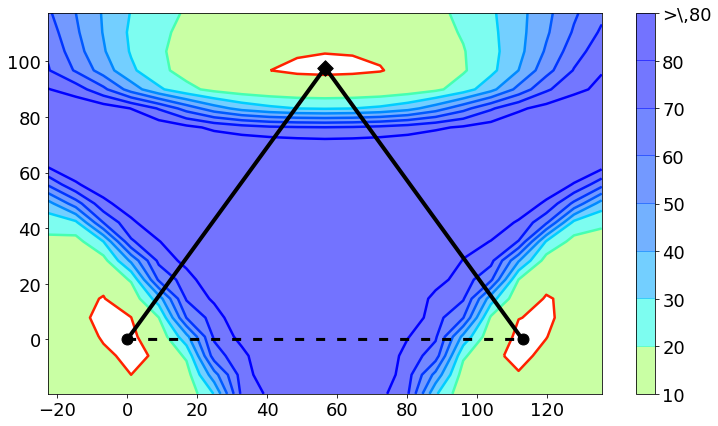

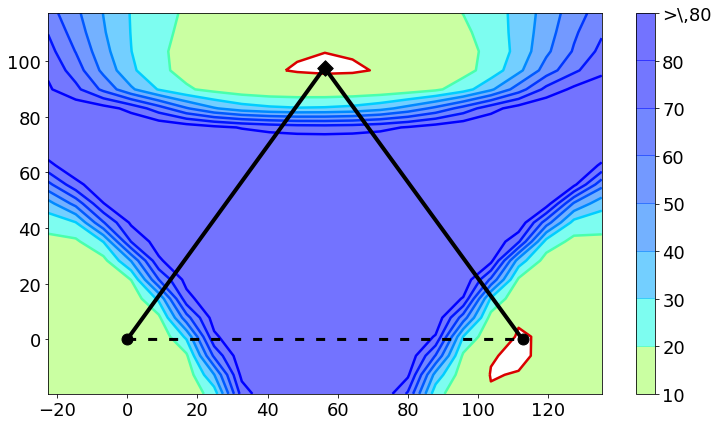

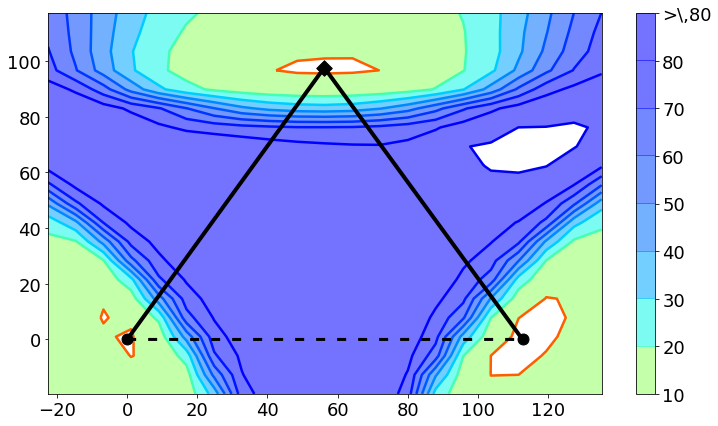

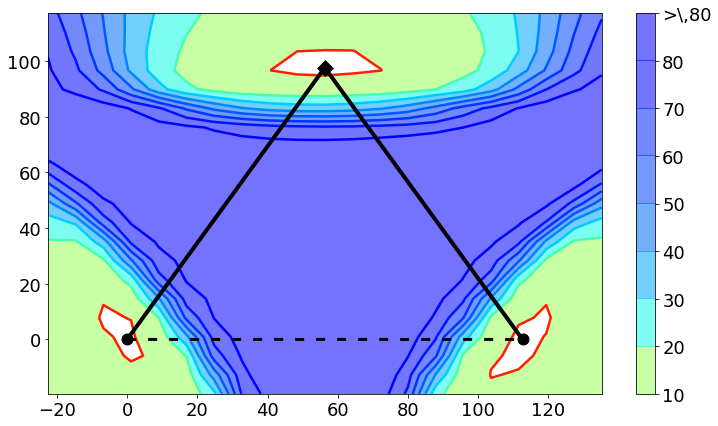

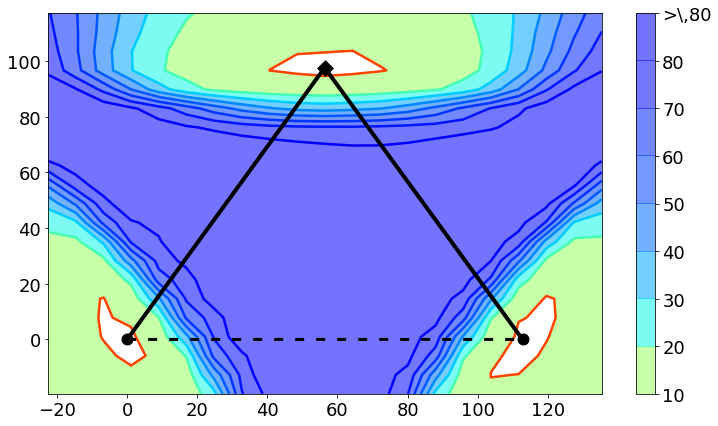

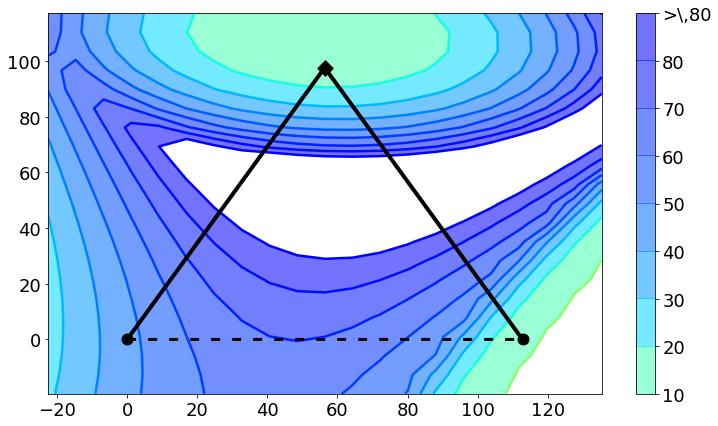

In [531]:
# levels = None

for f in l:
    X_test, y_test = make_dataset(f)    
    file = np.load(os.path.join('plots/', f, 'plane.npz'))

    y_pred = model(torch.Tensor(X_test).cuda())
    y_pred = y_pred.cpu().data.view(21, 21).numpy()

    plt.figure(figsize=(12.4, 7))

    
    contour, contourf, colorbar, levels = plane(
        file['grid'],
        file['te_err'],
        vmax=100,
        log_alpha=-1.0,
        N=7,
#         levels=levels
    )

    bend_coordinates = file['bend_coordinates']
    curve_coordinates = file['curve_coordinates']

    plt.scatter(bend_coordinates[[0, 2], 0], bend_coordinates[[0, 2], 1], marker='o', c='k', s=120, zorder=2)
    plt.scatter(bend_coordinates[1, 0], bend_coordinates[1, 1], marker='D', c='k', s=120, zorder=2)
    plt.plot(curve_coordinates[:, 0], curve_coordinates[:, 1], linewidth=4, c='k', label='w(t)', zorder=4)
    plt.plot(bend_coordinates[[0, 2], 0], bend_coordinates[[0, 2], 1], c='k', linestyle='--', dashes=(3, 4), linewidth=3, zorder=2)

    plt.margins(0.0)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    colorbar.ax.tick_params(labelsize=18)
    plt.show()
#     break

plt.figure(figsize=(12.4, 7))

contour, contourf, colorbar, _ = plane(
    file['grid'],
    y_pred,
    vmax=100,
    log_alpha=-1.0,
    N=7,
    levels=levels
)

bend_coordinates = file['bend_coordinates']
curve_coordinates = file['curve_coordinates']

plt.scatter(bend_coordinates[[0, 2], 0], bend_coordinates[[0, 2], 1], marker='o', c='k', s=120, zorder=2)
plt.scatter(bend_coordinates[1, 0], bend_coordinates[1, 1], marker='D', c='k', s=120, zorder=2)
plt.plot(curve_coordinates[:, 0], curve_coordinates[:, 1], linewidth=4, c='k', label='w(t)', zorder=4)
plt.plot(bend_coordinates[[0, 2], 0], bend_coordinates[[0, 2], 1], c='k', linestyle='--', dashes=(3, 4), linewidth=3, zorder=2)

plt.margins(0.0)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
colorbar.ax.tick_params(labelsize=18)
plt.show()
